In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- For the following time periods:
    - All time
    - Prev 3 months
    - 3 - 6 months in the past
    - 6 - 9 months in the past
- Calculate the following features:
- `price`: only for all time
- `category`: only for all time
- `title`: Embedding, only for all time
- `weeks_since_first_review`: only for all time
- `weeks_since_median_review`: only for all time
- `weeks_since_latest_review`: only for all time
- `last_review_summary`: Embedding, only for all time
- `last_review_is_verified`: only for all time
- `num_reviews`
- `sum_ratings`
- `avg_rating`
- `std_rating`
- `min_rating`
- `max_rating`
- `avg_review_length`
- `pct_verified_reviews`
- `product_bias`: avg_rating - global_avg_rating / global_std_rating
- reviewer aggs:
    - `avg_reviewer_total_spent`
    - `avg_reviewer_num_reviews`
    - `avg_reviewer_avg_price`
    - `avg_reviewer_avg_rating`
    - `avg_reviewer_std_rating`

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('amazon/amazon.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('amazon/product-ltv/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
utils.validate_feature_tables('product_ltv', conn)

Validating train
train labels size: 2,707,679 x 3
train feats size: 2,707,679 x 67

Validating val
val labels size: 166,978 x 3
val feats size: 166,978 x 67

Validating test
test labels size: 178,334 x 2
test feats size: 178,334 x 66

✅ All tables are valid!


In [4]:
%%sql train_df <<
from product_ltv_train_feats

In [5]:
infer_df_stype(train_df)

{'product_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'price': <stype.numerical: 'numerical'>,
 'category': <stype.text_embedded: 'text_embedded'>,
 'title': <stype.text_embedded: 'text_embedded'>,
 'ltv': <stype.numerical: 'numerical'>,
 'num_reviews_0_to_3': <stype.numerical: 'numerical'>,
 'sum_ratings_0_to_3': <stype.numerical: 'numerical'>,
 'avg_rating_0_to_3': <stype.numerical: 'numerical'>,
 'std_rating_0_to_3': <stype.numerical: 'numerical'>,
 'min_rating_0_to_3': <stype.categorical: 'categorical'>,
 'max_rating_0_to_3': <stype.categorical: 'categorical'>,
 'avg_review_length_0_to_3': <stype.numerical: 'numerical'>,
 'pct_verified_reviews_0_to_3': <stype.numerical: 'numerical'>,
 'product_bias_0_to_3': <stype.numerical: 'numerical'>,
 'avg_reviewer_num_reviews_0_to_3': <stype.numerical: 'numerical'>,
 'avg_reviewer_total_spent_0_to_3': <stype.numerical: 'numerical'>,
 'avg_reviewer_avg_price_0_to_3': <stype.numerical: 'numerical'>,
 'avg

In [7]:
utils.feature_summary_df(train_df.sample(20_000), 'ltv', classification=False)

,Label Corr.,Label MI,NaN %
price,0.240,4.173,0.0%
sum_ratings_0_to_3,0.398,0.150,46.1%
num_reviews_0_to_3,0.271,0.148,0.0%
weeks_since_latest_review,-0.015,0.120,10.2%
std_rating_0_to_3,0.020,0.112,65.8%
sum_ratings,0.222,0.107,10.2%
product_id,-0.015,0.102,0.0%
avg_reviewer_total_spent_0_to_3,0.007,0.100,46.1%
num_reviews,0.215,0.099,0.0%
product_bias_0_to_3,0.006,0.098,46.1%


## Feature Importances

In [8]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-amazon-product-ltv'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
%%sql val_df <<
select * from product_ltv_val_feats;

In [10]:
col_to_stype = task_to_stypes[TASK].copy()
del col_to_stype['title']
del col_to_stype['last_review_summary']
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [11]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

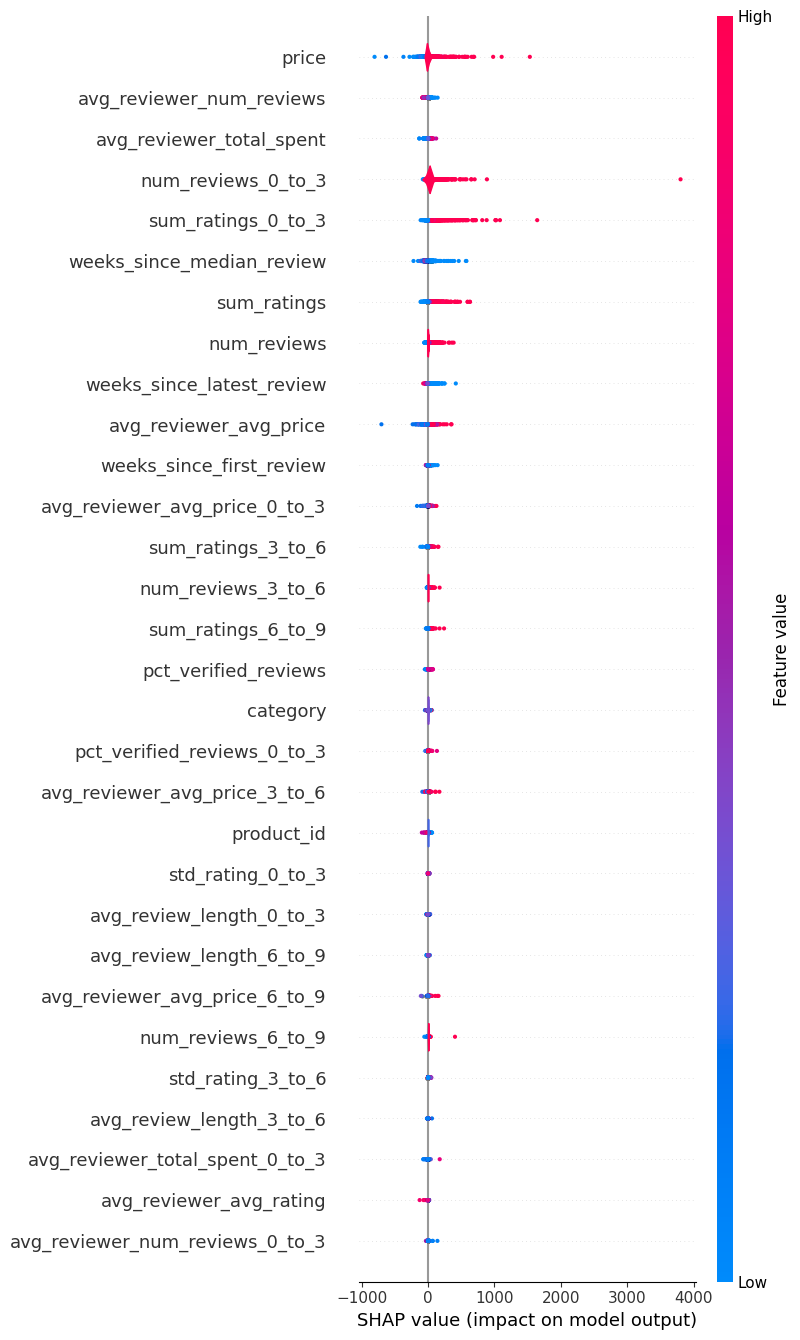

In [14]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

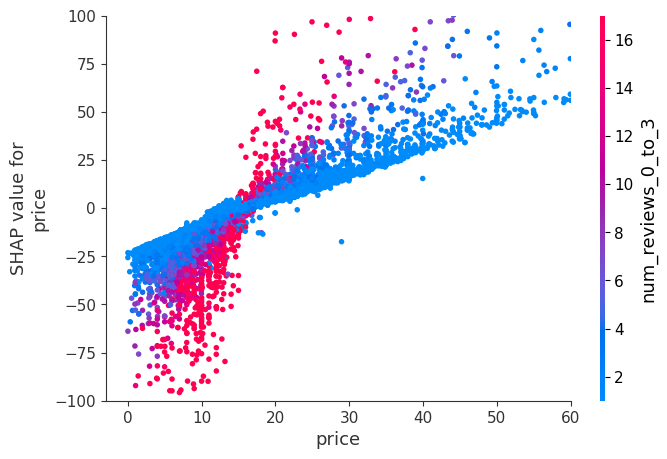

In [18]:
shap.dependence_plot('price', shap_values, val_arr, feature_names=feat_names, xmax=60, ymin=-100, ymax=100)

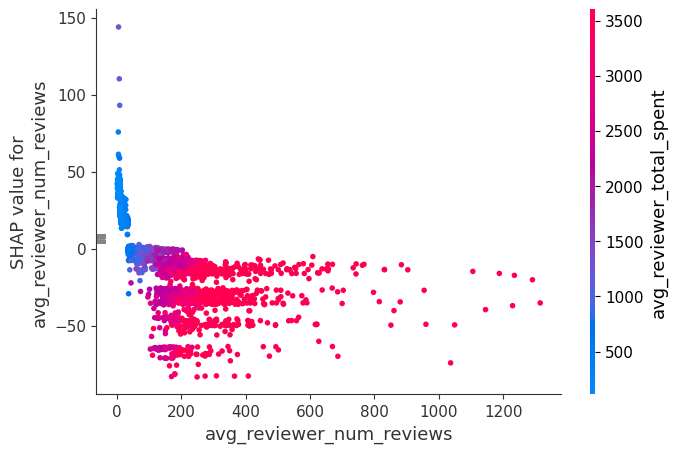

In [20]:
shap.dependence_plot('avg_reviewer_num_reviews', shap_values, val_arr, feature_names=feat_names)

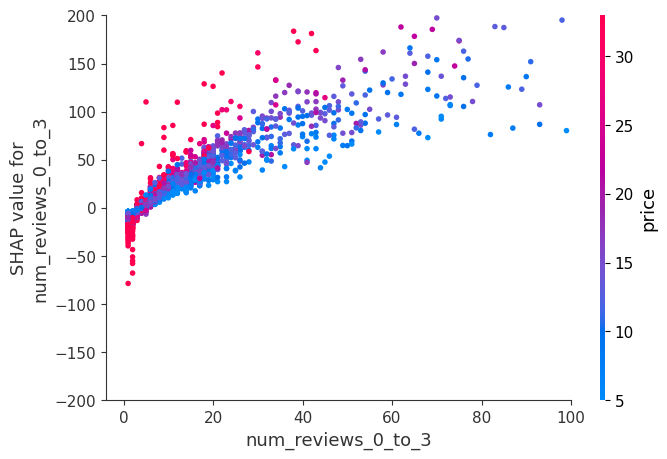

In [23]:
shap.dependence_plot('num_reviews_0_to_3', shap_values, val_arr, feature_names=feat_names, xmax=100, ymax=200)

In [17]:
conn.close()